# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install wandb

In [3]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eeuuais to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Datasets & DataLoaders & criterion setup

In [4]:
from torch.utils.data import Dataset
import torch
import numpy as np

# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        # 데이터 정규화: 0~1023 -> 0~1로 정규화
        self.data = torch.tensor(np.array(data) / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
        self.transform = transform  # transform을 추가하여 데이터 변환 가능하게

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx] if self.labels is not None else None

        # 변환을 적용하고자 하면, transform을 적용
        if self.transform:
            image = self.transform(image)  # 이미지에 transform 적용 (예: ToTensor())

        if self.labels is None:
            return image
        return image, label

In [5]:
# transform 정의 (여기서는 ToTensor()와 정규화를 예시로 사용)
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화 (예시)
])

In [6]:
# ResNet50 모델 정의
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(weights=None) # 사전학습 미사용
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 1로 변경
        self.model.avgpool = nn.AdaptiveAvgPool2d(1)  # 평균 풀링 조정

        in_features = self.model.fc.in_features  # ResNet50은 기본적으로 2048 (ResNet50의 마지막 출력 채널 수)
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Data Loading & Label Encoding

In [8]:
# 데이터 불러오기
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [9]:
train_df.shape

(769, 1026)

In [10]:
train_df.head()

,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TRAIN_000,building,251,196,51,63,68,78,189,34,...,85,195,63,30,73,65,63,201,251,248
1,TRAIN_001,building,247,184,203,237,255,255,193,255,...,242,239,241,242,242,241,241,241,240,238
2,TRAIN_002,building,217,223,232,231,239,212,109,115,...,96,90,103,166,191,163,190,190,206,231
3,TRAIN_003,cat,133,149,153,138,68,157,159,166,...,245,241,247,255,250,190,186,244,254,201
4,TRAIN_004,building,240,213,187,159,112,134,239,233,...,148,59,163,133,92,196,221,194,182,251


In [11]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

In [12]:
train_features

array([[251, 196,  51, ..., 201, 251, 248],
       [247, 184, 203, ..., 241, 240, 238],
       [217, 223, 232, ..., 190, 206, 231],
       ...,
       [208, 169, 175, ..., 167,  77, 112],
       [224, 242, 249, ..., 196, 195, 203],
       [212, 211, 211, ..., 243, 244, 243]])

# Sample Image

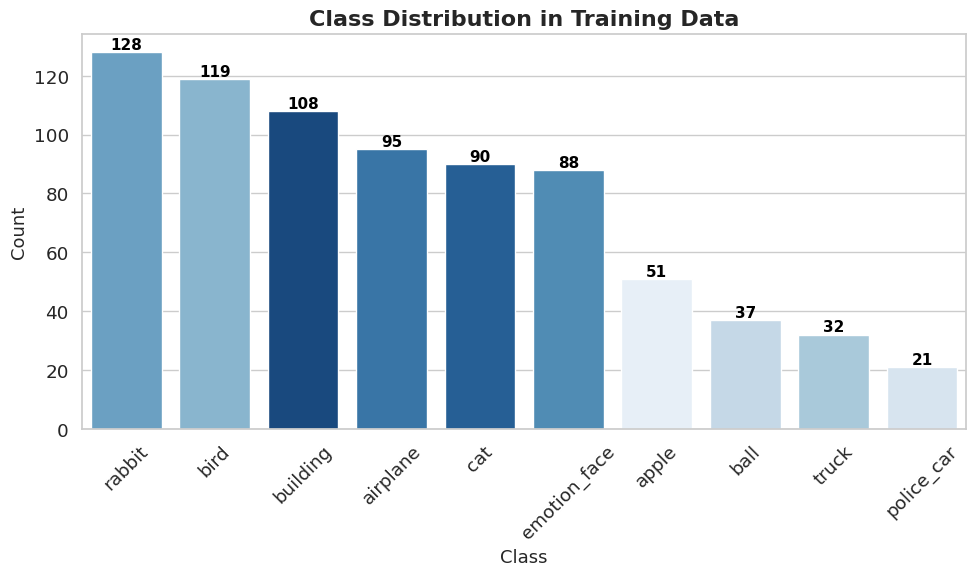

In [13]:
# 스타일 적용 (Seaborn 기본 테마 + 폰트 크기 조절)
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))

# 빈도수 기준으로 정렬 (내림차순)
class_order = train_df['label'].value_counts().index

# 막대그래프 (빈도가 많을수록 진한 색)
ax = sns.countplot(
    x='label',
    data=train_df,
    order=class_order,
    palette="Blues_r",  # 반전된 블루 색상 팔레트 (빈도가 많을수록 진한 색)
    hue='label'
)

# x축 라벨 회전
plt.xticks(rotation=45)

# 제목과 라벨 추가
plt.title("Class Distribution in Training Data", fontsize=16, weight='bold')
plt.xlabel("Class", fontsize=13)
plt.ylabel("Count", fontsize=13)

# 막대 위에 숫자 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, color='black', weight='bold')

plt.tight_layout()
plt.show()

# Config

In [16]:
# 하이퍼파라미터 정의
config = {
    'lr': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 64,
    'factor': 0.2,
    'patience': 5,
    'epochs': 10,
    'n_splits': 5
}

In [23]:
# wandb 기록
import wandb

wandb.init(
    project="icon-classification",  # 원하는 프로젝트 이름
    name="kfold-baseline01",            # 실험 이름
    group="experiment01",
    config=config
)

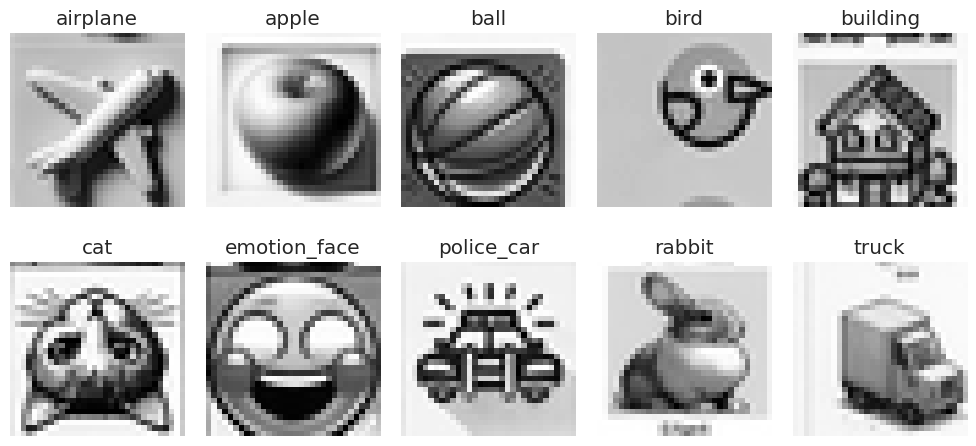

In [24]:
import wandb

# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# 유니크한 라벨을 찾기 (중복된 라벨은 하나만 추출)
unique_labels = np.unique(train_labels)

# 샘플 이미지를 그리면서 wandb에 기록
sample_images = []

for i, ax in enumerate(axes.flat):
    if i < len(unique_labels):
        label = unique_labels[i]

        # 해당 라벨을 가진 첫 번째 샘플 이미지 찾기
        img_idx = np.where(train_labels == label)[0][0]

        img = train_features[img_idx].reshape(32, 32)
        ax.imshow(img, cmap='gray')
        ax.set_title(label_encoder.inverse_transform([label])[0])  # 라벨을 텍스트로 표시
        ax.axis('off')

        # 각 이미지를 wandb에 추가
        sample_images.append(wandb.Image(img, caption=label_encoder.inverse_transform([label])[0]))

plt.tight_layout()
plt.show()

# ✅ Wandb에 샘플 이미지 기록
wandb.log({"sample_images": sample_images})

# # wandb 종료
# wandb.finish()

In [25]:
# 데이터 증강 함수
def add_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return np.clip(data + noise, 0, 1023) #  증강 후 범위 클리핑(0~1023으로 유지)

def scale_data(data, scale_factor=0.5):
    return data * scale_factor


# 1. train/val 먼저 분리
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

# 2. train 데이터만 증강
augmented_train_features = []
augmented_train_labels = []

for feature, label in zip(X_train, y_train):
    noisy_feature = add_noise(feature)
    scaled_feature = scale_data(feature)

    augmented_train_features.extend([feature, noisy_feature, scaled_feature])
    augmented_train_labels.extend([label, label, label])

augmented_train_features = np.array(augmented_train_features)
augmented_train_labels = np.array(augmented_train_labels)

# 3. val은 증강 없이 그대로 둠
X_val = np.array(X_val)
y_val = np.array(y_val)

In [26]:
augmented_train_features.shape

(2307, 1024)

# K-fold training

In [27]:
# K-Fold 설정
skf = StratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42) # 클래스 비율을 유지한 채 데이터를 n_splits개의 fold로 분할

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(augmented_train_features, augmented_train_labels)):
    print(f"📂 Fold {fold + 1} 시작")
    wandb.log({f'fold': fold + 1})

    # 데이터 분리
    X_train, X_val = augmented_train_features[train_idx], augmented_train_features[val_idx]
    y_train, y_val = augmented_train_labels[train_idx], augmented_train_labels[val_idx]

    # 데이터셋 & 로더
    train_dataset = ImageDataset(X_train, y_train)
    val_dataset = ImageDataset(X_val, y_val)
    test_dataset = ImageDataset(test_features, transform=None)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # 모델 초기화
    model = ResNet50Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config['patience'], factor=config['factor']) # 검증 손실이 개선되지 않으면 learning rate를 줄임


    # 학습
    best_val_acc = 0
    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # 검증
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        best_val_acc = max(best_val_acc, val_accuracy)
        scheduler.step(val_loss)

        # ✅ Wandb 기록
        # wandb.log({
        #     f"fold_{fold+1}/train_loss": train_loss,
        #     f"fold_{fold+1}/val_loss": val_loss,
        #     f"fold_{fold+1}/val_accuracy": val_accuracy,
        #     f"fold_{fold+1}/epoch": epoch
        # })
        wandb.log({
            f'train_loss_fold_{fold+1}': train_loss,
            f'val_accuracy_fold_{fold+1}': val_accuracy,
            f'val_loss_fold_{fold+1}': val_loss,
         })

    print(f"✅ Fold {fold+1} 최고 검증 정확도: {best_val_acc:.4f}")
    fold_accuracies.append(best_val_acc)

# 전체 교차검증 평균 정확도 기록
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
wandb.log({'cv_avg_accuracy': avg_accuracy})
print(f"\n📊 교차검증 평균 정확도: {avg_accuracy:.4f}")

# ✅ WandB 종료
wandb.finish()

📂 Fold 1 시작
✅ Fold 1 최고 검증 정확도: 0.9156
📂 Fold 2 시작
✅ Fold 2 최고 검증 정확도: 0.9351
📂 Fold 3 시작
✅ Fold 3 최고 검증 정확도: 0.9544
📂 Fold 4 시작
✅ Fold 4 최고 검증 정확도: 0.9544
📂 Fold 5 시작
✅ Fold 5 최고 검증 정확도: 0.9588

📊 교차검증 평균 정확도: 0.9437


cv_avg_accuracy,▁
fold,▁▃▅▆█
train_loss_fold_1,█▃▃▂▁▁▁▁▁▂
train_loss_fold_2,█▄▂▂▂▂▁▁▂▁
train_loss_fold_3,█▄▃▂▁▁▁▁▁▁
train_loss_fold_4,█▄▃▂▁▁▂▁▁▁
train_loss_fold_5,█▄▂▂▂▁▁▁▁▁
val_accuracy_fold_1,▁▁▇█████▇▇
val_accuracy_fold_2,▁▂▆▇▇▇▇▇▇█
val_accuracy_fold_3,▁▂▆▇██████
val_accuracy_fold_4,▁▃▆▇██▇███


# Full data training

In [28]:
import time

# WandB 프로젝트 시작
wandb.init(project='icon-classification',
           name='full-training01',
           config=config,
           group='experiment01')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 전체 데이터 학습용 하이퍼파라미터 설정
config = {
    'lr': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 64,
    'factor': 0.2,
    'patience': 7,
    'epochs': 100  # 에폭 수를 늘려 전체 학습에 적합하게 설정
}

# 데이터셋 & 로더
train_dataset = ImageDataset(augmented_train_features, augmented_train_labels)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

# 모델 초기화
model = ResNet50Model().to(device)
wandb.watch(model, log='all') # wandb : Metrics 기록
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config['patience'], factor=config['factor'])

# 학습
best_train_acc = 0
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0  # 훈련 정확도 계산을 위한 변수
    start_time = time.time()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 훈련 정확도 계산
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss /= len(train_loader)
    train_accuracy = correct / total
    scheduler.step(train_loss)

    # 학습 시간
    end_time = time.time()
    train_time = end_time - start_time

    # ✅ Wandb 기록
    wandb.log({
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_time': train_time,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'epoch': epoch
    })

    # 최고 훈련 정확도 기록
    best_train_acc = max(best_train_acc, train_accuracy)
    wandb.log({'best_train_accuracy': best_train_acc})  # 최고 정확도 기록

    print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Time: {train_time:.2f}s")

print(f"\n✅ 최종 훈련 정확도: {best_train_acc:.4f}")

# ✅ WandB 종료
wandb.finish()


Epoch 1/100, Train Loss: 2.2079, Train Accuracy: 0.3147, Time: 3.10s
Epoch 2/100, Train Loss: 1.0018, Train Accuracy: 0.6797, Time: 2.98s
Epoch 3/100, Train Loss: 0.8607, Train Accuracy: 0.7681, Time: 2.99s
Epoch 4/100, Train Loss: 0.4290, Train Accuracy: 0.8864, Time: 3.02s
Epoch 5/100, Train Loss: 0.6292, Train Accuracy: 0.8717, Time: 3.02s
Epoch 6/100, Train Loss: 0.4620, Train Accuracy: 0.8613, Time: 3.03s
Epoch 7/100, Train Loss: 0.2562, Train Accuracy: 0.9402, Time: 3.04s
Epoch 8/100, Train Loss: 0.1961, Train Accuracy: 0.9549, Time: 3.09s
Epoch 9/100, Train Loss: 0.4748, Train Accuracy: 0.9358, Time: 3.06s
Epoch 10/100, Train Loss: 0.2983, Train Accuracy: 0.9506, Time: 3.07s
Epoch 11/100, Train Loss: 0.2484, Train Accuracy: 0.9497, Time: 3.06s
Epoch 12/100, Train Loss: 0.3373, Train Accuracy: 0.9649, Time: 3.08s
Epoch 13/100, Train Loss: 0.3224, Train Accuracy: 0.9367, Time: 3.05s
Epoch 14/100, Train Loss: 0.1882, Train Accuracy: 0.9762, Time: 3.03s
Epoch 15/100, Train Loss: 0.6

best_train_accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
learning_rate,█████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▆▆▅▅▆▇▇█▇████▇▇███████████████████████
train_loss,█▄▄▂▂▂▂▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_time,▂▁▂▂▂▂▁▁▁▁▁▁█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
best_train_accuracy,1
epoch,99
learning_rate,0.0
train_accuracy,0.99913
train_loss,0.0266


# Inference

In [29]:
# 예측
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

# Submission

In [30]:
# 결과 저장

# 라벨 디코딩
predictions_decoded = label_encoder.inverse_transform(predictions)

submission = pd.DataFrame({"ID": test_df["ID"],
                           "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)

In [31]:
submission

,ID,label
0,TEST_000,bird
1,TEST_001,cat
2,TEST_002,emotion_face
3,TEST_003,building
4,TEST_004,truck
...,...,...
245,TEST_245,police_car
246,TEST_246,cat
247,TEST_247,building
248,TEST_248,police_car
